In [12]:
import matplotlib.pyplot as plt
import gymnasium as gym
import numpy as np
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [16]:
# Constants

GAMMA = 0.9
ALPHA = 0.1
num_passengers_states = 5
num_destinations = 4
locations = {0:[0,0], 1:[0,4], 2:[4,0], 3:[4,3]}


In [3]:
# testing the environment

env = gym.make('Taxi-v3')
n_states = env.observation_space.n
n_actions = env.action_space.n
print(n_states, n_actions)

500 6


Environment description<br>
    - 5 x 5<br>
    - at start of episode taxi starts at random position and passenger<br>
        is at a random poistion of the 4 designated locations.<br>
    - taxi drives to passengers location and drops him off (episode ends)
    <br>
    - total states = 25 * 5 * 4 

# SMDP Q-Learning


Whole action set:<br>
    - 6 primitive actions: 0 - 5<br>
    - move taxi to each of the 4 destinations [options]: 6 - 9<br>


In [5]:
def epsilon_greedy_policy(Q, state, epsilon):
    '''Epsilon greedy policy,
        returns the action to be taken based on the Q-values'''
    if np.random.uniform() < epsilon:
        return np.random.choice(env.action_space.n-2)
    else:
        return np.argmax(Q[state])

In [6]:
def Option(env, state, goal, Q, eps):
    '''The option function that chooses the action for the 
    agent to take based on the goal, basically 
    we have four options: each corresponding to a destination'''

    option_done = False
    x,y,pickup,dropoff = env.decode(state)

    if([x,y] == locations[goal]):
        option_done = True
        if(pickup == goal):
            #Agent is at pickup location, so choose to pickup
            option_act = 4
        else:
            #Agent is at dropoff location, so choose to dropoff
            option_act = 5
    else:
        #Agent is not at the goal location, so move towards
        option_act = epsilon_greedy_policy(Q[goal], 5*x+y, epsilon=eps) 
    return option_done, option_act
    

In [18]:
def Learning(Option, num_episodes, num_options):
    Q_for_options = {i:np.zeros((env.observation_space.n//20,env.action_space.n-2)) for i in range(num_options)}
    Q_SMDP = np.zeros((num_passengers_states*num_destinations, num_options))
    rewards = []
    eps = {i:0.01 for i in range(num_options)}
    eps_min = 0.01
    eps_decay = 0.99
    eps_main = 0.5

    for i in tqdm(range(num_episodes)):
        state, _ = env.reset()
        episode_reward = 0
        done = False
        
        while not done :
            option_done = False
            total_reward_episode = 0
            x,y, pickup, dropoff = env.decode(state)
            sub_state = num_destinations*pickup + dropoff
            option = epsilon_greedy_policy(Q_SMDP, sub_state, eps_main)
            eps_main = max(eps_min, eps_main*eps_decay)
            count_steps = 0

            while not option_done and not done:
                option_done, option_act = Option(env,state,option,Q_for_options,eps[option])
                next_state, reward, done,_ ,_ = env.step(option_act)

                total_reward_episode = GAMMA*total_reward_episode + reward
                episode_reward+=reward
                count_steps+=1
                [x,y,_,_]=  list(env.decode(state))
                [x1,y1,_,_]=  list(env.decode(next_state))

                eps[option] = max(eps_min,eps_decay*eps[option])
                reward_suggercoat = reward 
                if(option_done):
                    reward_suggercoat = 20
                if option_act<4:
                    Q_for_options[option][5*x+y, option_act] = Q_for_options[option][5*x+y, option_act] + ALPHA*(reward_suggercoat + GAMMA*np.max(Q_for_options[option][5*x1+y1, :]) - Q_for_options[option][5*x+y, option_act])
                state = next_state
            
            _, _, pickup, dropoff = env.decode(state)
            sub_state_next = num_destinations*pickup + dropoff
            Q_SMDP[sub_state, option] = Q_SMDP[sub_state, option] + ALPHA*(episode_reward + (GAMMA**count_steps)*np.max(Q_SMDP[sub_state_next,:]) - Q_SMDP[sub_state, option])
        rewards.append(total_reward_episode)
    return Q_SMDP, Q_for_options, rewards

In [19]:
def plots(Q_SMDP, Q_for_options, reward, location):
    plt.figure(figsize = (10,5))
    avg_rews1 = [np.average(reward[i:i+100]) for i in range(len(reward)-100)]
    plt.plot(avg_rews1,label = 'Model Score', color = 'red')
    # plt.plot([9.7 for i in range(len(avg_rews1))],label = 'Solved line')
    plt.xlabel('Episodes')
    plt.ylabel('score averaged over previous 100 runs')
    plt.grid()
    plt.title('Reward vs Episodes')
    plt.legend()
    plt.savefig(location + "reward_vs_episodes.png")
     

    #Plots the learnt policy for each option
    figure, axis = plt.subplots(2,2,figsize=(10,10))
    for i in range(2):
        for j in range(2):
            directions = {0:'↓', 1:'↑', 2:'→', 3:'←'}
            annot_text = np.vectorize(directions.get)(np.argmax(Q[2*i+j],axis=1).reshape(5,5))
            ax = sns.heatmap(np.argmax(Q_for_options[2*i+j],axis=1).reshape(5,5),ax=axis[i,j],annot = annot_text,fmt='', cmap="viridis", linewidths=0.5, linecolor='white')
            axis[i,j].set_title("Policy learnt for option {}".format(i*2+j))
            c_bar = ax.collections[0].colorbar
            c_bar.set_ticks([i for i in range(4)])
            c_bar.set_ticklabels(['↓','↑','→','←'])
    plt.savefig(location + "learned_Q_values.png")
    plt.show()

    # Assuming Q_SMDP is the variable containing the Q_SMDP values
    Qmax_SMDP = np.argmax(Q_SMDP, axis=1).reshape(5, 4)
    labels = {0:'Y',1:'B', 2:'R', 3:'G'}
    annot_text = np.vectorize(labels.get)(Qmax_SMDP)
    ax = sns.heatmap(Qmax_SMDP,annot = annot_text,fmt='', cmap="viridis", linewidths=0.5, linecolor='white')
    plt.title("Policy learnt for SMDP")
    plt.xlabel("Passenger dropoff")
    plt.ylabel("Passenger Location")
    c_bar = ax.collections[0].colorbar
    c_bar.set_ticks([i for i in range(4)])
    c_bar.set_ticklabels(['Y','B','R','G'])
    plt.savefig(location + "learned_Q_values_SMDP.png")
    plt.show()

In [20]:
Q_SMDP, Q_for_options, rewards_SMDP = Learning(Option, 15000, 4)


100%|██████████| 15000/15000 [00:21<00:00, 688.36it/s]


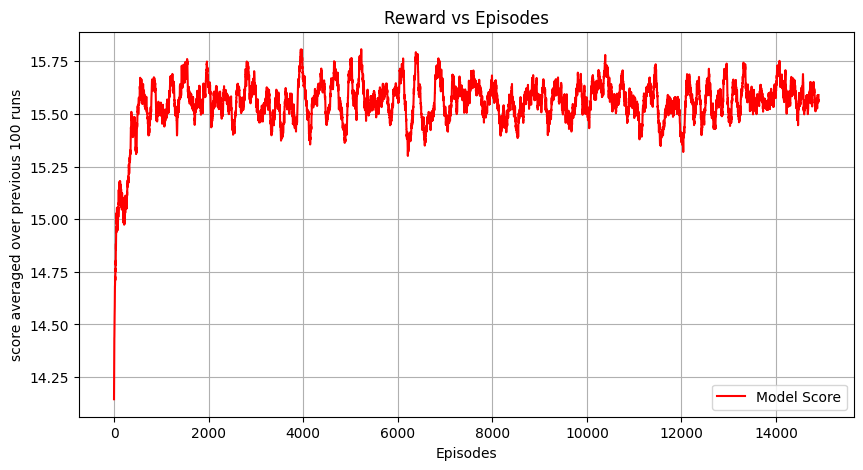

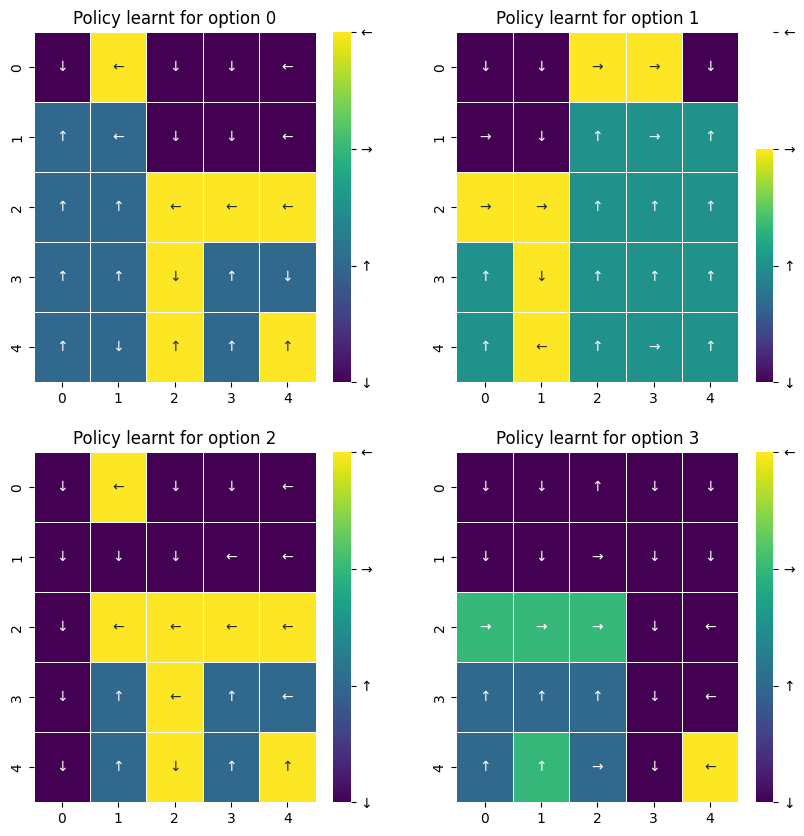

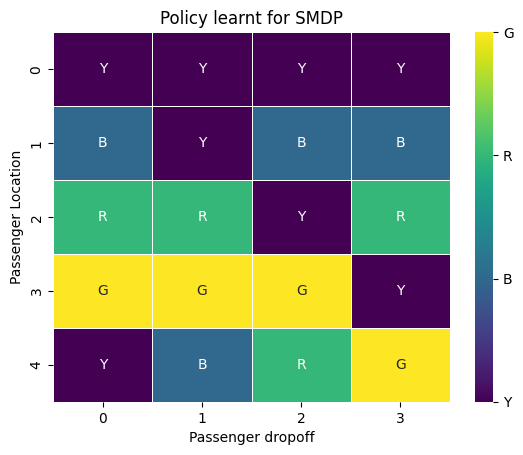

In [133]:
plots(Q_SMDP, Q_for_options, rewards_SMDP, location = "Plots/SMDP/")

### Task-3, Alternative options

In [23]:
# we want to go to these options
# bottom_left = [[0,0],[1,0],[0,1],[1,1]]
# top_right = [[4,4],[4,3],[3,4],[3,3]]
# bottom_right = [[0,4],[0,3],[1,4],[1,3]]
# top_right = [[4,0],[3,0],[4,1],[3,1]]

bottom_left = [[0,0]]
top_left = [[4,0]]
bottom_right = [[0,4]]
top_right = [[4,3]]

def alternative_option(env, state, goal, Q, eps):
    x,y,pickup,dropoff = env.decode(state)
    option_done = False

    if goal == 0 and [x,y] in bottom_left:
        option_done = True    
    elif goal == 1 and [x,y] in bottom_right:
        option_done = True
    elif goal == 2 and [x,y] in top_left:
        option_done = True
    elif goal == 3 and [x,y] in top_right:
        option_done = True
    else:
        option_done = False
    
    
    if option_done:
        if(pickup<4):
            if [x,y] == locations[pickup]:
                option_act = 4
            elif [x,y] == locations[dropoff]:
                option_act = 5
            else:
                option_act = epsilon_greedy_policy(Q[goal], 5*x+y, epsilon=eps)
        else:
            option_act = epsilon_greedy_policy(Q[goal], 5*x+y, epsilon=eps)
    else:
        option_act = epsilon_greedy_policy(Q[goal], 5*x+y, epsilon=eps)


    # print(option_done, option_act, [x,y], pickup, dropoff)
    return option_done, option_act

In [24]:
Q_SMDP_alternate, Q_for_options_alternate, rewards_alternate = Learning(alternative_option, 1500, 4)

  0%|          | 0/1500 [00:10<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
plots(Q_SMDP_alternate, Q_for_options_alternate, rewards_alternate, location = "Plots/Alternate/")

# Intra option Q-Learning

One drawback to SMDP learning methods is that they need to execute an option to
termination before they can learn about it. Because of this, they can only be applied
to one option at a time–the option that is executing at that time. More interesting
and potentially more powerful methods are possible by taking advantage of the
structure inside each option. In particular, if the options are Markov and we are
willing to look inside them, then we can use special temporal-difference methods
to learn usefully about an option before the option terminates. This is the main idea
behind intra-option methods<br>
Intra-option methods are examples of off-policy learning methods (Sutton and
Barto, 1998) because they learn about the consequences of one policy while actually
behaving according to another, potentially different policy. Intra-option methods
can be used to simultaneously learn about many different options from the same
experience. Moreover, they can learn about the values of executing certain options
without ever executing those options.<br>
This is the idea of off-policy training—to make full
use of whatever experience occurs in order to learn as much possible about all op-
tions, irrespective of their role in generating the experience<br>

In [98]:
passenger_locations = 5
drop_locations = 4
n_options = 4

In [99]:

def Sub(state, nPas = passenger_locations, nDrop = drop_locations):
  #returns the substate for the SMDP
  _,_,pas,drop = env.decode(state) 
  subState = nDrop*pas+drop 
  return subState 

In [100]:
def Option(env, state, goal, Q, eps):
    option_done = False
    x,y,pickup,dropoff = env.decode(state)
    #print(x,y,pickup,dropoff,locations[goal])
    if([x,y] == locations[goal]):
        option_done = True
        if(pickup == goal):
            #Agent is at pickup location, so choose to pickup
            option_act = 4
        else:
            #Agent is at dropoff location, so choose to dropoff
            option_act = 5
    else:
        #Agent is not at the goal location, so move towards
        option_act = epsilon_greedy_policy(Q[goal], 5*x+y, epsilon=eps) 
    return option_done, option_act
    

In [106]:
# Training the agent
def learn_intra_option(Option, num_episodes):
  rewards = []
  q_values_IOQL = np.zeros((passenger_locations*drop_locations,n_options))
  updates_IOQL = np.zeros((passenger_locations*drop_locations,n_options))

  # Q value for each option
  Q = {i:np.zeros((env.observation_space.n//20,env.action_space.n-2)) for i in range(n_options)} #Q-values for each option

  # a dictionary to store the epsilon values for each option
  eps = {i:0.01 for i in range(n_options)}
  eps_min = 0.01
  eps_decay = 0.99
  eps_main = 0.5

  count = 0

  # Iterate over Number of episodes
  for i in tqdm.tqdm(range(num_episodes)):
      state, _ = env.reset()    
      done = False
      episode_reward = 0

      # While episode is not over
      while not done:
          # Choose action  
          _,_,pickup,dropoff = env.decode(state) 
          subState = drop_locations*pickup+dropoff      
          action = epsilon_greedy_policy(q_values_IOQL, subState, epsilon=eps_main)
          eps_main = max(eps_min,eps_main*eps_decay)
          

          option = action
          find_passenger = False
          prev = state  
          while not find_passenger and not done:
              #print(env,state,Q,option,eps[option])
              find_passenger,option_act = Option(env,state,option, Q, eps[option])
              next_state, reward,done,_ ,_ = env.step(option_act)
              
              episode_reward+=reward
              #Option Policy Learning
              [x,y,_,_]=  list(env.decode(state)) 
              [x1,y1,_,_]=  list(env.decode(next_state)) 

              eps[option] = max(eps_min,eps_decay*eps[option])
              reward_surr = reward
              if find_passenger:
                reward_surr = 20
              if option_act<4:  
                Q[option][5*x+y, option_act] = Q[option][5*x+y, option_act] + ALPHA*(reward_surr + GAMMA*np.max(Q[option][5*x1+y1, :]) - Q[option][5*x+y, option_act])



              #finding all options giving same action call
              
              for o in range(n_options):
                optdone_o, optact_o = Option(env,state,o,Q,eps[o])
                if optact_o == option_act:
                  eps[o] = max(eps_min,eps_decay*eps[o])
                  if optdone_o:
                    q_values_IOQL[Sub(state), o] += ALPHA*(reward + GAMMA*np.max(q_values_IOQL[Sub(next_state), :]) - q_values_IOQL[Sub(state), o])
                  else:
                    q_values_IOQL[Sub(state), o] += ALPHA*(reward + GAMMA*q_values_IOQL[Sub(next_state), o] - q_values_IOQL[Sub(state), o]) 

                  updates_IOQL[Sub(state), o] += 1
              state = next_state 
          
      rewards.append(episode_reward) 
  return q_values_IOQL, Q, rewards

In [107]:
Q_IOQL, Q_for_options_IOQL, rewards_IOQL = learn_intra_option(Option, num_episodes=15000)

100%|██████████| 15000/15000 [00:59<00:00, 252.45it/s]


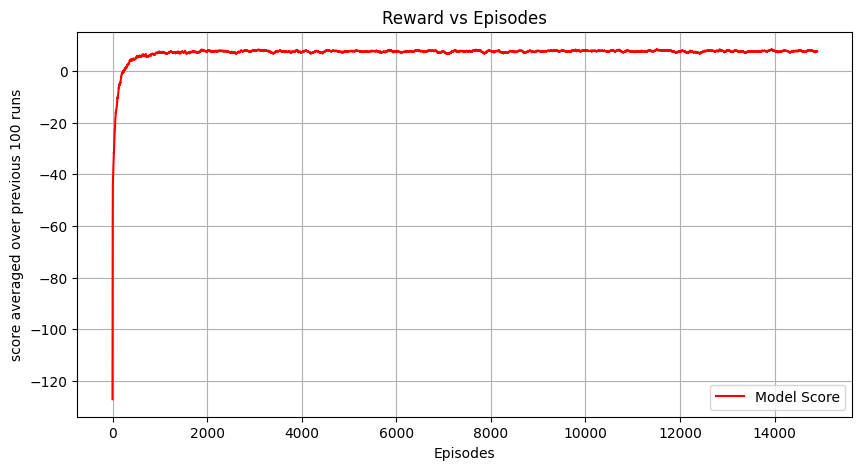

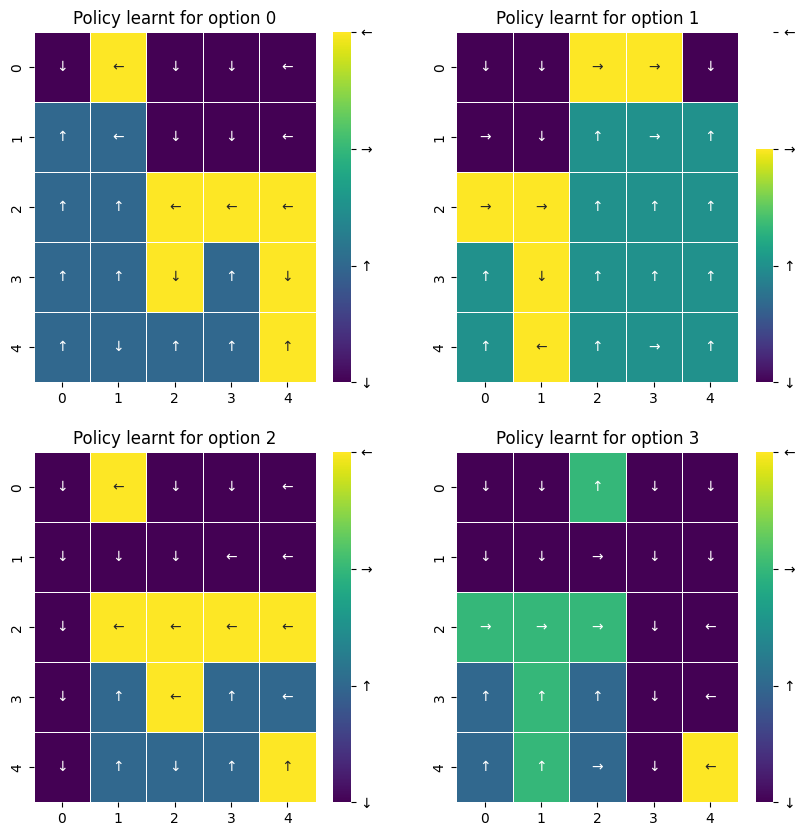

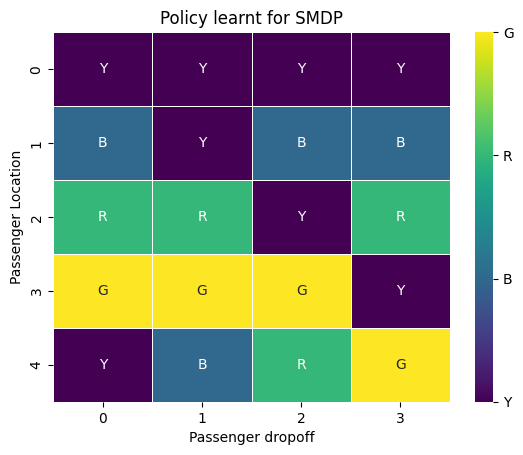

In [113]:
plots(Q_IOQL, Q_for_options_IOQL, rewards_IOQL, location="Plots/IOQL/")

## Comapring performance of SMDP vs IOQL

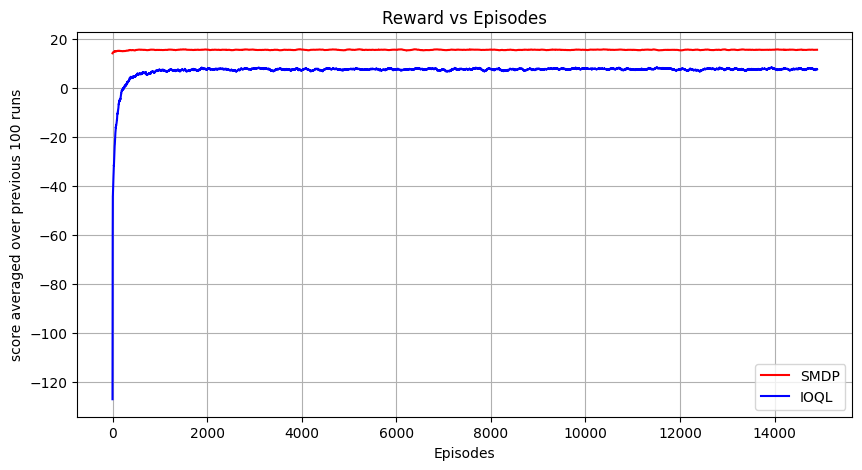

In [117]:
plt.figure(figsize = (10,5))
avg_rews1 = [np.average(rewards_SMDP[i:i+100]) for i in range(len(rewards_SMDP)-100)]
plt.plot(avg_rews1,label = 'SMDP', color = 'red')
avg_rews2 = [np.average(rewards_IOQL[i:i+100]) for i in range(len(rewards_IOQL)-100)]
plt.plot(avg_rews2,label = 'IOQL', color = 'blue')
# plt.plot([9.7 for i in range(len(avg_rews1))],label = 'Solved line')
plt.xlabel('Episodes')
plt.ylabel('score averaged over previous 100 runs')
plt.grid()
plt.title('Reward vs Episodes')
plt.legend()
plt.show()